In [8]:
!pip install duckdb

In [9]:
%matplotlib inline

# adding project dirs to path so code may be referenced from the notebook
import sys
sys.path.insert(0, '..')

In [10]:
import duckdb
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import config
import utils

In [11]:
# load usgs gages
%time
gdf = utils.get_usgs_gages()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs


In [12]:
gdf

,nwm_feature_id,from_node,to_node,longitude,latitude,gage_id,geometry
feature_id,,,,,,,
9206,7086109,0,7087369,-95.668182,48.987789,05106000,POINT (-95.66818 48.98779)
12736,7040481,0,7040415,-96.272133,47.795300,05078520,POINT (-96.27213 47.79530)
12777,7053819,0,7053689,-96.203247,47.746620,05078470,POINT (-96.20325 47.74662)
13372,7111205,0,7112189,-91.738281,47.763351,05125039,POINT (-91.73828 47.76335)
15635,7110249,0,7110187,-91.653671,47.835423,05124982,POINT (-91.65367 47.83542)
...,...,...,...,...,...,...,...
2775156,15489152,0,15489114,-75.380020,44.601517,04263000,POINT (-75.38002 44.60152)
2776119,15465127,0,15465121,-74.979881,44.840992,04268000,POINT (-74.97988 44.84099)
2776269,15476223,0,15476217,-75.076462,44.849354,04265432,POINT (-75.07646 44.84935)


<AxesSubplot: >

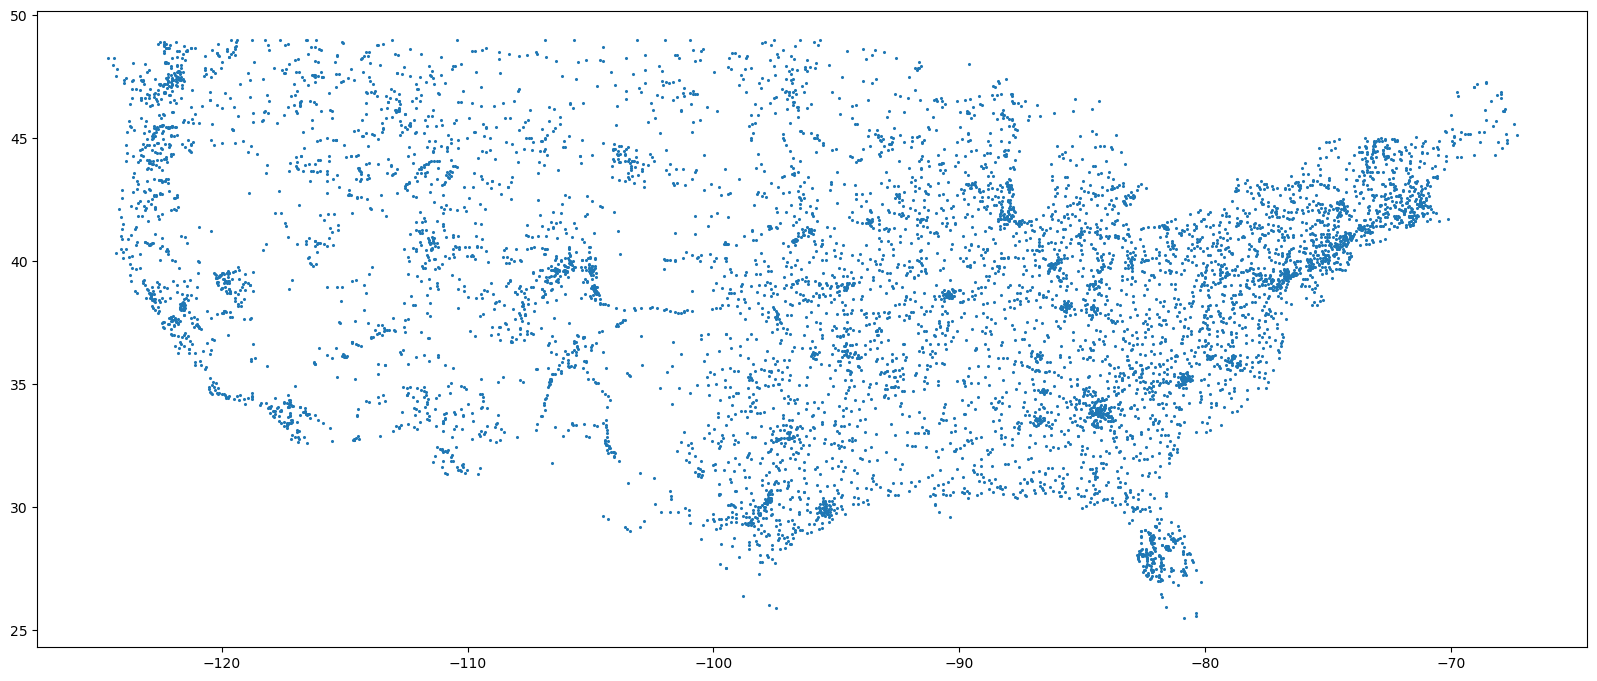

In [63]:
gdf.plot(markersize=1.5, figsize=(20,10))

In [52]:
# Query some forcast data from parquet files
import importlib
import queries
importlib.reload(queries)

<module 'queries' from '/home/matt/repos/hydro-evaluation/src/evaluation/queries/queries.py'>

In [57]:
query = queries.calculate_nwm_feature_metrics(
    config.MEDIUM_RANGE_PARQUET,
    config.USGS_PARQUET,
    group_by=["nwm_feature_id"],
    order_by=["observed_average"],
    filters=[
        {
            "column": "reference_time",
            "operator": "=",
            "value": "2023-01-03 12:00:00"
        },
    ]
)
print(query)
df = duckdb.query(query).to_df()
df

{'column': 'reference_time', 'operator': '=', 'value': '2023-01-03 12:00:00'}

        WITH joined as (
            SELECT 
                nd.reference_time,
                nd.value_time,
                nd.nwm_feature_id,   
                nd.value as forecast_value, 
                nd.configuration,  
                nd.measurement_unit,     
                nd.variable_name,
                ud.value as observed_value,
                ud.usgs_site_code,
                nd.value_time - nd.reference_time as lead_time
            FROM '/home/matt/cache/parquet/medium_range/*.parquet' nd 
            JOIN '/home/matt/cache/nwm/route_link_conus.parquet' nux 
                on nux.nwm_feature_id = nd.nwm_feature_id 
            JOIN '/home/matt/cache/parquet/usgs/*.parquet' ud 
                on nux.gage_id = ud.usgs_site_code 
                and nd.value_time = ud.value_time 
                and nd.measurement_unit = ud.measurement_unit
                and nd.variable_name = ud.var

,nwm_feature_id,intercept,covariance,corr,r_squared,forecast_count,observed_count,forecast_average,observed_average,forecast_variance,observed_variance,max_forecast_delta,bias
0,3109,NaN,0.000000e+00,NaN,NaN,240,240,88.002677,-999999.000000,5.628236e+02,0.000000e+00,1.000141e+06,-1.000087e+06
1,188199,NaN,0.000000e+00,NaN,NaN,240,240,7.090890,-999999.000000,9.091478e-03,0.000000e+00,1.000006e+06,-1.000006e+06
2,190871,NaN,0.000000e+00,NaN,NaN,240,240,463.003246,-999999.000000,1.141885e+00,0.000000e+00,1.000467e+06,-1.000462e+06
3,231167,NaN,0.000000e+00,NaN,NaN,240,240,0.076515,-999999.000000,4.818755e-02,0.000000e+00,1.000000e+06,-9.999991e+05
4,239166,NaN,0.000000e+00,NaN,NaN,237,237,65.154812,-999999.000000,3.984745e-01,0.000000e+00,1.000065e+06,-1.000064e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6963,11866736,130081.971391,5.735323e+08,0.204692,0.041899,240,240,152886.510124,308612.500000,1.011498e+09,7.761579e+09,-2.124192e+05,1.557260e+05
6964,1841415,200876.657729,4.361339e+08,0.115612,0.013366,238,238,218496.458049,412764.705882,1.392888e+09,1.021695e+10,-2.543620e+05,1.942682e+05
6965,19088319,521654.660979,-6.117597e+08,-0.627754,0.394075,110,110,416407.303977,432390.909091,3.778652e+08,2.513311e+09,-6.537425e+04,1.598361e+04
6966,7474830,173181.788018,4.420921e+09,0.887339,0.787370,240,240,279935.312240,502025.000000,1.193963e+09,2.079007e+10,-3.106832e+05,2.220897e+05


<AxesSubplot: >

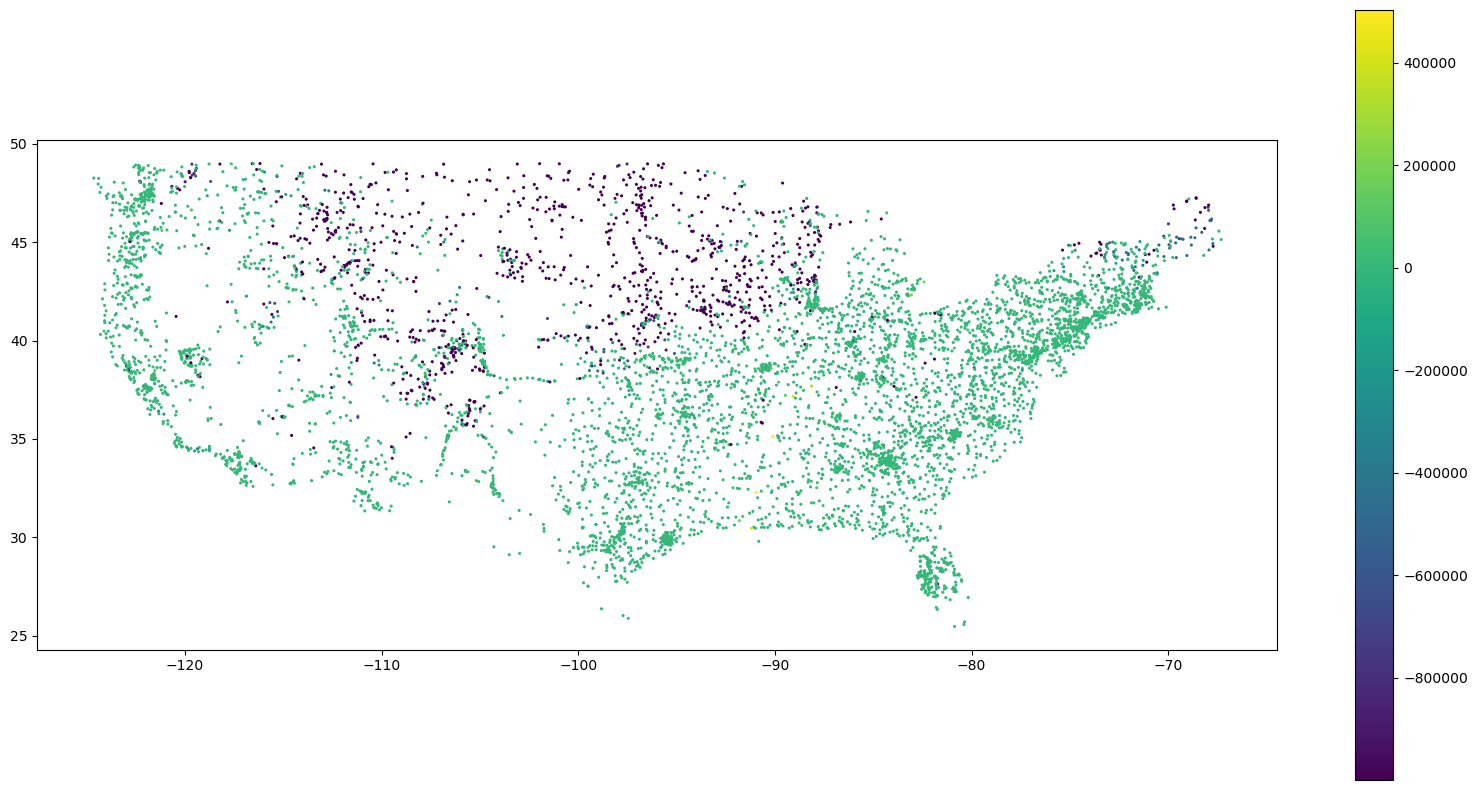

In [67]:
# Join query to basins
gdf_map = gdf.merge(df, left_on="nwm_feature_id", right_on="nwm_feature_id")

# Filter to CA
# gdf_map = gdf_map.loc[gdf_map["catchment_id"].str.startswith("18")]

gdf_map.plot("observed_average", legend=True, markersize=1.5, figsize=(20,10))

In [68]:
query = queries.get_joined_nwm_feature_timeseries(
    config.MEDIUM_RANGE_PARQUET,
    config.USGS_PARQUET,
    filters=[
        {
            "column": "reference_time",
            "operator": "=",
            "value": "2023-01-03 12:00:00"
        },
        {
            "column": "nwm_feature_id",
            "operator": "=",
            "value": "19266232"
        },
    ]
)

df = duckdb.query(query).to_df()
df

{'column': 'reference_time', 'operator': '=', 'value': '2023-01-03 12:00:00'}
{'column': 'nwm_feature_id', 'operator': '=', 'value': '19266232'}


,reference_time,value_time,nwm_feature_id,forecast_value,configuration,measurement_unit,variable_name,observed_value,usgs_site_code,lead_time
0,2023-01-03 12:00:00,2023-01-03 13:00:00,19266232,382855.81250,medium_range_mem1,ft3/s,streamflow,381000.0,07289000,0 days 01:00:00
1,2023-01-03 12:00:00,2023-01-03 14:00:00,19266232,383591.09375,medium_range_mem1,ft3/s,streamflow,380000.0,07289000,0 days 02:00:00
2,2023-01-03 12:00:00,2023-01-03 15:00:00,19266232,384609.56250,medium_range_mem1,ft3/s,streamflow,380000.0,07289000,0 days 03:00:00
3,2023-01-03 12:00:00,2023-01-03 16:00:00,19266232,385954.34375,medium_range_mem1,ft3/s,streamflow,380000.0,07289000,0 days 04:00:00
4,2023-01-03 12:00:00,2023-01-03 17:00:00,19266232,387636.03125,medium_range_mem1,ft3/s,streamflow,380000.0,07289000,0 days 05:00:00
...,...,...,...,...,...,...,...,...,...,...
235,2023-01-03 12:00:00,2023-01-04 17:00:00,19266232,408480.50000,medium_range_mem1,ft3/s,streamflow,376000.0,07289000,1 days 05:00:00
236,2023-01-03 12:00:00,2023-01-07 00:00:00,19266232,384021.56250,medium_range_mem1,ft3/s,streamflow,450000.0,07289000,3 days 12:00:00
237,2023-01-03 12:00:00,2023-01-09 12:00:00,19266232,397511.75000,medium_range_mem1,ft3/s,streamflow,507000.0,07289000,6 days 00:00:00
238,2023-01-03 12:00:00,2023-01-09 18:00:00,19266232,394902.37500,medium_range_mem1,ft3/s,streamflow,517000.0,07289000,6 days 06:00:00


<AxesSubplot: xlabel='value_time'>

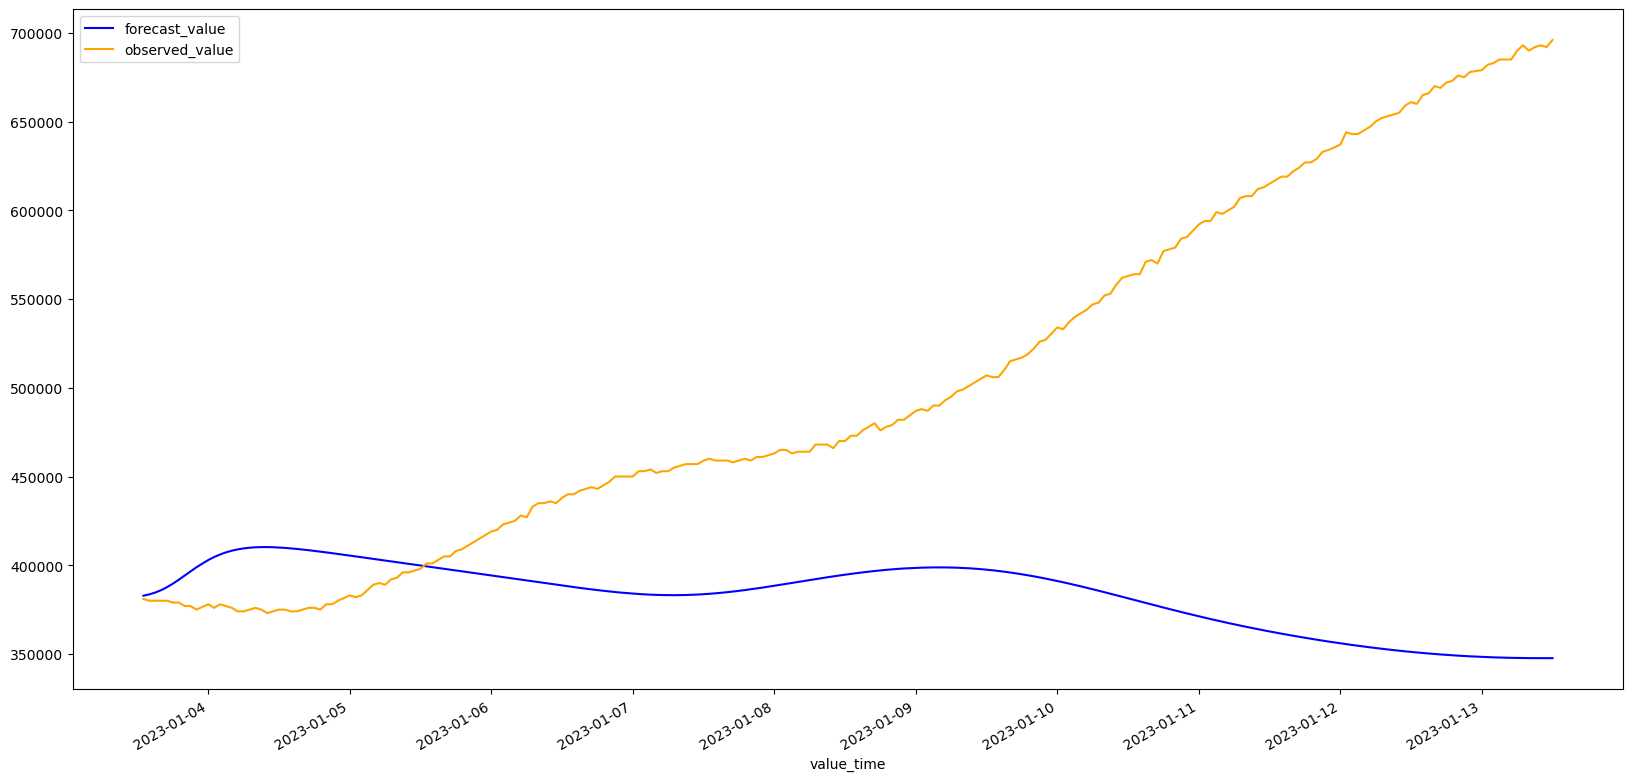

In [69]:
ax = plt.gca()
df.plot(x= 'value_time', y="forecast_value", ax=ax, figsize=(20,10), color="blue", stacked=True)
df.plot(x= 'value_time', y="observed_value", ax=ax, figsize=(20,10), color="orange", stacked=True)